In [17]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import glob
import os
from speechbrain.pretrained import EncoderClassifier
import torchaudio
from tqdm import tqdm
from spectralcluster import SpectralClusterer
import matplotlib.patches as mpatches

In [20]:
clusterer = SpectralClusterer(min_clusters=2, max_clusters=4)

wavfile = "./diarization_test_files/HinEng_Codeswitch.wav"
classifier = EncoderClassifier.from_hparams(source="./best_model", hparams_file='hparams_inference.yaml', savedir="./best_model")
signal, fs = torchaudio.load(wavfile)

win_length = int(16000*3) # 1 second segment
hop = int(16000*0.3) # 0.2 second segment hop

wav = signal
embeddings = []
data = []

for j in tqdm(range(0, wav.shape[-1]-win_length, hop)):
    inp = wav[:,j:j+win_length]
    output_probs, score, index, text_lab = classifier.classify_batch(inp)
    emb = classifier.encode_batch(inp)[0][0]
    lang_prediction = text_lab[0]
    embeddings.append(list(emb.numpy()))
    timings_start = (j/16000)
    timings_end = ((j+win_length)/16000)
    data.append([timings_start, timings_end, lang_prediction])

embeddings = np.array(embeddings)
labels = clusterer.predict(embeddings)
data = np.column_stack([data, labels])
diary = pd.DataFrame(data, columns = ['start','end','language', 'specCLuster'])

100%|█████████████████████████████████████████| 381/381 [00:37<00:00, 10.08it/s]


In [21]:
new_diary = []
start = diary["start"].to_numpy()
end = diary["end"].to_numpy()

for i in range(len(start)):
    new_diary.append({"start": float(start[i]), "stop": float(end[i])})

def create_labelling(labels, wav_splits):
    times = [((s["start"] + s["stop"]) / 2) for s in wav_splits]
    labelling = []
    start_time = 0

    for i,time in enumerate(times):
        if i>0 and labels[i]!=labels[i-1]:
            temp = [str(labels[i-1]),float(start_time),float(time)]
            labelling.append(tuple(temp))
            start_time = time
        if i==len(times)-1:
            temp = [str(labels[i]),float(start_time),float(time)]
            labelling.append(tuple(temp))

    return labelling
  
labelling = create_labelling(diary["language"].to_numpy(), new_diary)

In [22]:
file1 = open('./diarization_test_files/HinEngCodeswitch.txt', 'r')
Lines = file1.readlines()

di = {"Eng" : "en", "Tel" : "te", "Hin" : "hi"}
ground_truths = []
# Strips the newline character
for line in Lines:
    start, end, label = line.split()
    ground_truths.append((di[label], round(float(start),1), round(float(end),1)))

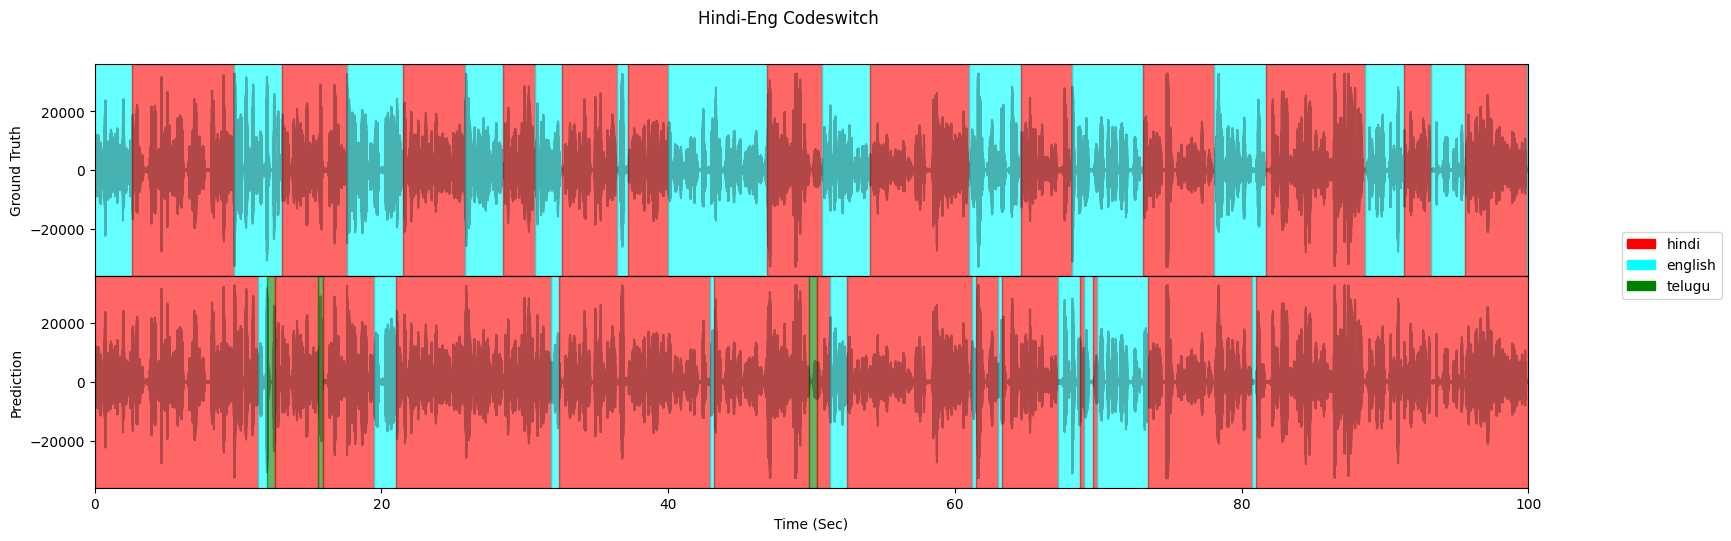

In [23]:
import wave, sys

raw = wave.open(wavfile)
signal = raw.readframes(-1)
signal = np.frombuffer(signal, dtype ="int16")
f_rate = raw.getframerate()
x_lim = 100

time = np.linspace(0, len(signal) / f_rate,num = len(signal))

fig, ax = plt.subplots(2, gridspec_kw = {'hspace':0})
fig.set_size_inches(18.5, 5.5)
fig.suptitle("Hindi-Eng Codeswitch")
red_patch = mpatches.Patch(color='red', label='hindi')
blue_patch = mpatches.Patch(color='cyan', label='english')
green_patch = mpatches.Patch(color='green', label='telugu')

plt.legend(handles=[red_patch, blue_patch, green_patch], loc='center', bbox_to_anchor=(1.1, 1.05))
ax[0].plot(time, signal, color="black", alpha=0.3)
ax[0].set_xticklabels([])
ax[0].set_ylabel("Ground Truth")
ax[0].set_xlim([0, x_lim])

for i, val in enumerate(ground_truths):
    if val[0] == "en":
        ax[0].axvspan(val[1], val[2], alpha=0.6, color='cyan')
    elif val[0] == "hi":
        ax[0].axvspan(val[1], val[2], alpha=0.6, color='red')
    elif val[0] == "te":
        ax[0].axvspan(val[1], val[2], alpha=0.6, color='green')
        
ax[1].plot(time, signal, color="black", alpha=0.3)
ax[1].set_ylabel("Prediction")
ax[1].set_xlabel("Time (Sec)")
ax[1].set_xlim([0, x_lim])

for i, val in enumerate(labelling):
    if val[0] == "en":
        ax[1].axvspan(val[1], val[2], alpha=0.6, color='cyan')
    elif val[0] == "hi":
        ax[1].axvspan(val[1], val[2], alpha=0.6, color='red')
    elif val[0] == "te":
        ax[1].axvspan(val[1], val[2], alpha=0.6, color='green')

plt.savefig("HinEng_Diar.png")

In [24]:
import simpleder

error = simpleder.DER(ground_truths, labelling)
print("DER={:.3f}".format(error))

DER=0.401
